### Демонстрационный файл

> Программа выполняет полный анализ текстового корпуса:
> извлечение признаков, фильтрация текста, обработка слов,
> составление вектора. Полученные данные сохраняются в БД.
> Далее, выполняется классификация выбранного корпуса текстов
> на основе полученных входных и выходных векторов.
> Все параметры для настройки системы анализа текстовой 
> информации задаются файлом param.json


**Подключение внешних библиотек:**

In [2]:
import sys
sys.path.append('..')
from DbInteraction import DbInteraction
from Param import Param
from OpenTexts import OpenTexts
from CorpusParser import CorpusParser
from Dictionary import Dictionary
from Vectorizer import Vectorizer
from CorpusAnalyzer import CorpusAnalyzer
import time
import json
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

**Инициализация работы с БД:**

In [5]:
t = time.localtime()
compilationTime = "{0}.{1}.{2} {3}:{4}".format(t.tm_year, t.tm_mon, 
                                               t.tm_mday, t.tm_hour, 
                                               t.tm_min)

p = Param('../param.json') #инициализация класса с параметрами работы
db = DbInteraction() #иниц. класса для работы с БД
db.initFullAnalysis(p.readDBCorpusPath()) #иниц. класса для работы с БД
# отправка в него пути к БД
corpusID = db.getCorpusID() #сохранение актуального ID, который
# является индексом строки в БД
db.updateCorpus('name', p.readName(), corpusID) #добавление начальной инфо
# рмации о корпусе. данные считываются с параметров и отправляются
db.updateCorpus('language', p.readLanguage(), corpusID) #
db.updateCorpus('stemType', p.readStemType(), corpusID) #
db.updateCorpus('stopWordsType', p.readStopWordsType(), corpusID) #
db.updateCorpus('metric', p.readMetric(), corpusID) #
db.updateCorpus('compilationTime', compilationTime, corpusID)


db.addInfo()
db.updateInfo('name', p.readName(), 1) #добавление начальной инфо
# рмации о корпусе. данные считываются с параметров и отправляются
db.updateInfo('language', p.readLanguage(), 1)
db.updateInfo('stemType', p.readStemType(), 1)
db.updateInfo('stopWordsType', p.readStopWordsType(), 1)
db.updateInfo('metric', p.readMetric(), 1)
db.updateInfo('corpus_ID', corpusID, 1)
db.updateInfo('compilationTime', compilationTime, 1)
print('Готово!')

Готово!


**Получение списка используемых текстов и отправка имени текста, 
имени темы и исходного текста в БД:**

In [6]:
analyzer = CorpusAnalyzer() # аналайзер дополняет БД оставшимися данными

op = OpenTexts(p.readDocCorpusPath()) # иниц. класса для работы с исходными
# текстами
op.searchFolder() # выбор метода для своего типа исходных данных 
# (поиск папок с файлами, файлов с текстами или другой)  
# searchFolder, searchTxt, searchAlt
# !!! мб перенести выбор метода в json параметры. а внутри класса пусть
# сам определяет, какой метод надо использовать, на основе параметров 
while(op.hasNext()): # проверка на наличие следующего текста
    tempData = op.getNext() # извлечение базовой информации из 
    # файла, сохранение в словаре
    lastID = db.addTexts() # добавление новой строки в бд для 
    # информации по текстам и возврат её номера
    db.updateTexts('name', tempData['name'], lastID) # обновление 
    # данных в соответствующей строке
    db.updateTexts('topicName', tempData['topicName'], lastID) #
    db.updateTexts('baseText', tempData['baseText'], lastID) #
    
    analyzer.addTopicName(tempData['topicName'])
    db.updateTexts('topicNum', analyzer.getTopicNum(tempData['topicName']), lastID)
    # <- аналайзер необходим, для получения списка используемых топиков.
    # он запоминает имена топиков, присваивает им имена и, в данном месте,
    # отправляет имена в БД, для отчётности и для дальнейшего формирования
    # выходного вектора.
print('Готово!')

Готово!


**Обновление таблицы БД со списком тем для отчётности:**

In [7]:
for name, val, i in zip(analyzer.getList().keys(), 
                     analyzer.getList().values(),
                     range(analyzer.getNumOfTopics())):
    db.addTopicList() # добавление новой строки в бд для списка топиков
    db.updateTopicList('name', name, i+1)
    db.updateTopicList('topicNum', val, i+1)
    db.updateTopicList('numOfTexts', analyzer.getTopicCount(name), i+1)
    # <- обновление информации в таблице со списком топиков
    # общая информация, для отчетности
print('Готово!')

Готово!


**Фильтрация исходных текстов. Отправка обработанных текстов в БД:**

In [8]:
parser = CorpusParser(language = p.readLanguage(), 
                      stemType = p.readStemType(),
                      stopWordsType = p.readStopWordsType)
tempText = ''
for i in range(db.getTextsSize()):
    tempText = db.getTextsData('baseText', i+1)[0][0]
    tempText = parser.parsing(tempText)
    db.updateTexts('formattedText', tempText, i+1)
# <- выполняется полный проход по всем сырым текстам в бд
# забираются сырые тексты, отправляются на очистку
# возвращаются тексты после фильтрации и отправляются в БД обратно
print('Готово!')

Готово


**Фомирование общего словаря для всех текстов и отправка
словаря в БД:**

In [9]:
d = Dictionary()
for i in range(db.getTextsSize()):
    d.addData(db.getTextsData('formattedText', i+1)[0][0])
    tempDict = d.getLastDictionary()
    tempStr = json.dumps(tempDict)
    tempStr = tempStr.replace('"', '""') 
    db.updateTexts('localDictionary', tempStr, i+1)
    # <- добавление в БД локальных словарей в виде json строки
print('Готово!')

Готово!


**Обновление общей информации, для отчётности:**

In [10]:
if p.saveDictionary == True:
    tempDict = d.getGlobalDictionary()
    for key, val in tempDict.items():
        lastID = db.addDictionary()
        db.updateDictionary('word', key, lastID)
        db.updateDictionary('value', val, lastID)
        # <- добавление глобального словаря в бд, целиком
        #!!! нужно пофиксить. работает слишком медленно
   
    
  
inputSize = d.getGlobalSize()
outputSize = db.getTopicListSize()
corpusSize = db.getTextsSize()

db.updateCorpus('numOfTopics', outputSize, corpusID)
db.updateInfo('numOfTopics', outputSize, 1)
db.updateCorpus('numOfTexts', corpusSize, corpusID)
db.updateInfo('numOfTexts', corpusSize, 1)
db.updateCorpus('dictionarySize', inputSize, corpusID)
db.updateInfo('dictionarySize', inputSize, 1)
# <- обновление общей информации в БД (для отчетности)
print('Готово!')

Готово!


**Фомирование входных и выходных векторов к каждому тексту,
отправка их в БД:**

In [11]:
v = Vectorizer()
v.addGlobDict(d.getGlobalDictionary())
for i in range(db.getTextsSize()):
    tempStr = db.getTextsData('localDictionary', i+1)[0][0]
    tempDict = json.loads(tempStr)
    tempArray = v.getVecFromDict(tempDict)
    tempStr = json.dumps(tempArray)
    db.updateTexts('inputVector', tempStr, i+1)
    # <- инициализация векторизатора, отправка глобального словаря в 
    # него, извлечение из бд локального словаря, преобразование 
    # его из json-строки в стандартный словарь отправка словаря 
    # в векторизатор, получение массива преобразование массива 
    # в json-строку и отправка обратно в бд
    topicNum = db.getTextsData('topicNum', i+1)[0][0]
    db.updateTexts('outputVector', 
                   json.dumps(v.numToOutputVec(topicNum, outputSize)),
                   i+1)
    # <- извлечение номера топика для формирования входного вектора
    # и отправки этого вектора в БД
print('Готово!')

Готово!


**Настройка объекта для последовательного извлечения 
входных и выходных данных:**

In [12]:
c = db.getConnectionData()
ds = tf.data.Dataset.from_generator(
    db.generator(corpusSize, db.getDataCorpusName(), 'inputVector', 'outputVector'),
    output_types=(tf.float64, tf.float64),
    output_shapes=(tf.TensorShape((inputSize, )), tf.TensorShape((outputSize, ))))
    # <- использование генератора, который содержит весь набор данных и 
    # извлекает их, по необходимости
print('Готово!')

Готово!


**Разделение данных на обучающую и тестовую:**

In [13]:
ds = ds.shuffle(buffer_size=corpusSize,
                reshuffle_each_iteration=True)
trainSize = int(corpusSize*p.getTrainPercentage()/100)
ds_train = ds.take(trainSize)
ds_val = ds.skip(trainSize)
ds = None
ds_train = ds_train.batch(30)
ds_val = ds_val.batch(30)
print('Готово!')

Готово!


**Формирование и подготовка нейронной сети:**

In [14]:
model = tf.keras.Sequential()

model.add(layers.Dense(inputSize, activation='relu'))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(outputSize, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.RMSprop(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
print('Готово!')

Готово!


**Начало процесса обучения сети:**

In [15]:
history = model.fit(ds_train,
                    epochs=100,
                    validation_data=ds_val)
print('Готово!')

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1/1 [==============================] - 1s 522ms/step - loss: 1.3869 - categorical_accuracy: 0.2143 - val_loss: 1.8686 - val_categorical_accuracy: 0.5714
Epoch 2/100
1/1 [==============================] - 0s 71ms/step - loss: 1.9626 - categorical_accuracy: 0.4286 - val_loss: 5.4087 - val_categorical_accuracy: 0.2857
Epoch 3/100
1/1 [==============================] - 0s 68ms/step - loss: 5.8971 - categorical_accuracy: 0.2857 - val_loss: 1.4713 - val_categorical_accuracy: 0.4286
Epoch 4/100
1/1

1/1 [==============================] - 0s 58ms/step - loss: 1.1499e-04 - categorical_accuracy: 1.0000 - val_loss: 9.5342e-05 - val_categorical_accuracy: 1.0000
Epoch 46/100
1/1 [==============================] - 0s 58ms/step - loss: 1.6492e-04 - categorical_accuracy: 1.0000 - val_loss: 1.4516e-04 - val_categorical_accuracy: 1.0000
Epoch 47/100
1/1 [==============================] - 0s 72ms/step - loss: 1.7866e-04 - categorical_accuracy: 1.0000 - val_loss: 1.6512e-04 - val_categorical_accuracy: 1.0000
Epoch 48/100
1/1 [==============================] - 0s 72ms/step - loss: 1.5340e-04 - categorical_accuracy: 1.0000 - val_loss: 1.4223e-04 - val_categorical_accuracy: 1.0000
Epoch 49/100
1/1 [==============================] - 0s 76ms/step - loss: 1.2885e-04 - categorical_accuracy: 1.0000 - val_loss: 1.7280e-04 - val_categorical_accuracy: 1.0000
Epoch 50/100
1/1 [==============================] - 0s 69ms/step - loss: 1.3222e-04 - categorical_accuracy: 1.0000 - val_loss: 1.5327e-04 - val_cate

1/1 [==============================] - 0s 75ms/step - loss: 9.6133e-06 - categorical_accuracy: 1.0000 - val_loss: 8.6171e-06 - val_categorical_accuracy: 1.0000
Epoch 93/100
1/1 [==============================] - 0s 71ms/step - loss: 6.3181e-06 - categorical_accuracy: 1.0000 - val_loss: 4.6321e-06 - val_categorical_accuracy: 1.0000
Epoch 94/100
1/1 [==============================] - 0s 72ms/step - loss: 5.8497e-06 - categorical_accuracy: 1.0000 - val_loss: 7.3058e-06 - val_categorical_accuracy: 1.0000
Epoch 95/100
1/1 [==============================] - 0s 59ms/step - loss: 8.1998e-06 - categorical_accuracy: 1.0000 - val_loss: 7.0674e-06 - val_categorical_accuracy: 1.0000
Epoch 96/100
1/1 [==============================] - 0s 73ms/step - loss: 5.5432e-06 - categorical_accuracy: 1.0000 - val_loss: 7.4761e-06 - val_categorical_accuracy: 1.0000
Epoch 97/100
1/1 [==============================] - 0s 79ms/step - loss: 6.7183e-06 - categorical_accuracy: 1.0000 - val_loss: 5.5517e-06 - val_cate

**Построение графиков для отчета:**

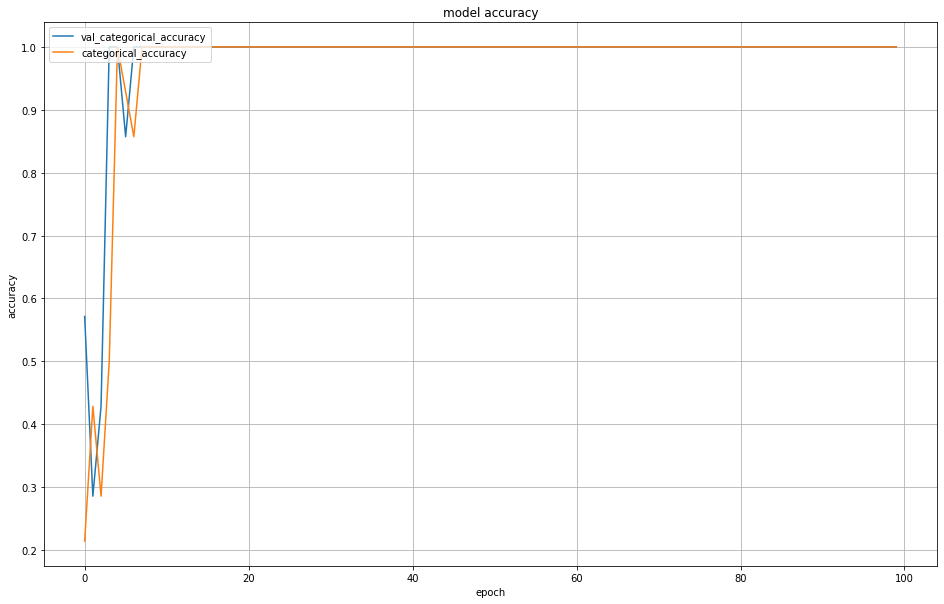

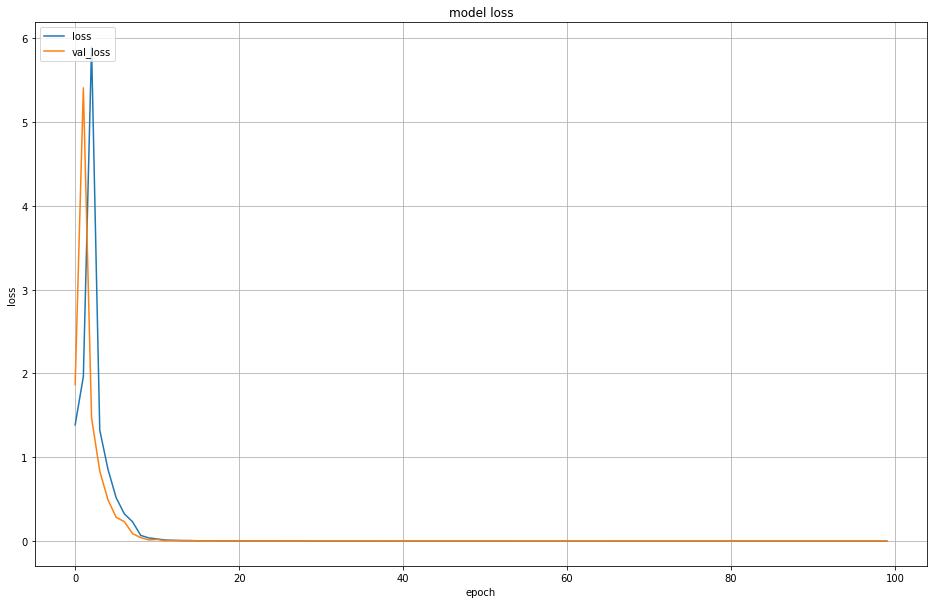

Готово!


In [16]:
#summarize history for accuracy
plt.figure(figsize=(16, 10))
plt.plot(history.history['val_categorical_accuracy'])
plt.plot(history.history['categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_categorical_accuracy', 'categorical_accuracy'], loc='upper left')
plt.grid(True)
plt.show()

#summarize history for loss
plt.figure(figsize=(16, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.grid(True)
plt.show()
print('Готово!')